In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
import matplotlib

In [28]:
star_images_train = np.load('star_images_train.npy')
star_classes_train = np.load('star_classes_train.npy')
star_embeddings_train = np.load('star_embeddings_train.npy')

star_images_test = np.load('star_images_test.npy')
star_classes_test = np.load('star_classes_test.npy')

In [29]:
# We define node/class colours for plot consistency
cmap = matplotlib.colormaps.get_cmap('tab10')
color_type = [cmap(i) for i in star_classes_train]

# Transform node/class values to class names
value_to_type = {0 : "O5V", 1: "A0V", 2 : "F5V", 3 : "M5V"}

# PCA from previously

In [30]:
def standardise(X):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.

    Returns:
    Xbar: Standardised data.

    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std[std==0] = 1.
    Xbar = (X - mu) / std
    
    return Xbar

In [31]:
# Standardise data for PCA
X2_norm = standardise(star_embeddings_train)

In [32]:
def covariance_matrix(X):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.

    Returns:
    Xbar: Computes the data covariance matrix.

    """
    return np.dot(X.T, X) / len(X)

def pca_function(X, k):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.
    k: Number of principal components.

    Returns:
    X_pca: Transformed data.
    eigenvectors: First k eigenvectors of C.
    eigenvalues: First k eigenvalues of C.

    """
    # Computing the covariance matrix
    C = covariance_matrix(X)

    # Computing the eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(C, k, which='LM', return_eigenvectors=True)
    
    # Sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(abs(eigenvalues))[::-1]
    eigenvalues = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:,sorted_index]

    # Projecting the data onto the directions of eigenvectors
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

In [33]:
k = 2 # We want first 2 principal components 

X2_pca, eigenvectors, eigenvalues = pca_function(X2_norm, k)

# Kernel PCA

In [17]:
def kernel_matrix(X1,X2,alpha):
    # Return kernel matrix using Laplacian kernel
    
    n1,m1 = X1.shape
    n2,m2 = X2.shape
    kernel = np.zeros((n1,n2))

    for i in range(n1):
        exponent = np.linalg.norm(X2 - X1[i],ord=2,axis=1)**2 
        kernel[i,:] = np.exp(-alpha*exponent)

    return kernel

In [23]:
def kernel_pca_function(X, k, alpha=0.3):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.
    k: Number of principal components.

    Returns:
    X_pca: Transformed data.
    eigenvectors: First k eigenvectors of C.
    eigenvalues: First k eigenvalues of C.

    """

    K = kernel_matrix(X, X, alpha)

    one_n = np.ones((K.shape[0], K.shape[0])) / K.shape[0]
    K_tilde = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Computing the eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(K_tilde, k, which='LM', return_eigenvectors=True)
    
    # Sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(abs(eigenvalues))[::-1]
    eigenvalues = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:,sorted_index]

    # Projecting the data onto the directions of eigenvectors
    K_pca = K_tilde.dot(eigenvectors)

    return K_pca, eigenvectors, eigenvalues

In [24]:
k = 2 # We want first 2 principal components 

X2_kernel_pca, eigenvectors, eigenvalues = kernel_pca_function(X2_norm, k, alpha=0.01)

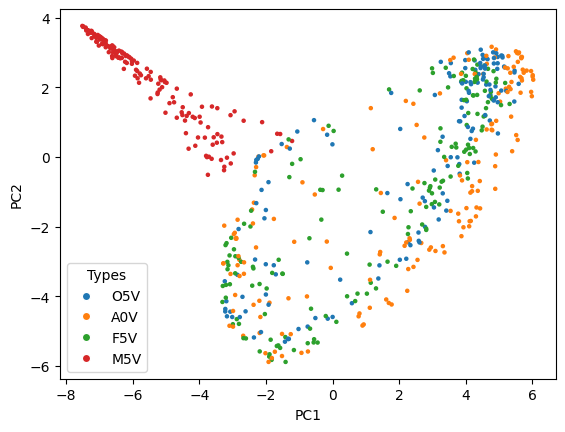

In [25]:
plt.scatter(X2_kernel_pca[:, 0], X2_kernel_pca[:, 1], c=color_type, s=5)

# create legend for node types
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Types')

plt.xlabel('PC1')
plt.ylabel('PC2');

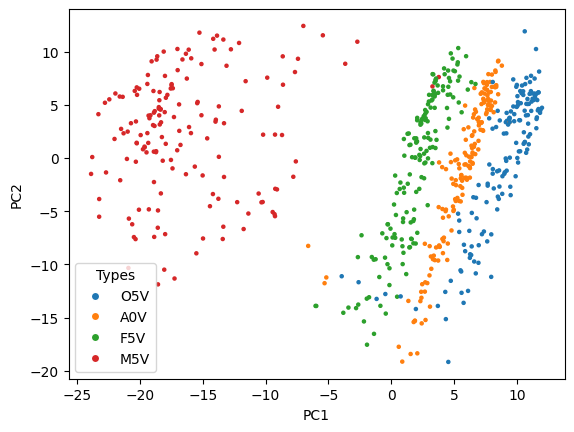

In [73]:
plt.scatter(X2_pca[:, 0], X2_pca[:, 1], c=color_type, s=5)

# create legend for node types
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Types')

plt.xlabel('PC1')
plt.ylabel('PC2');

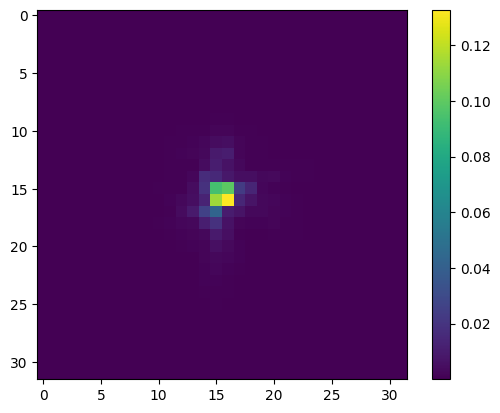

In [100]:
plt.imshow(star_images_train[0])
plt.colorbar()

In [103]:
star_images_train.min()

1.7995547109183768e-06

In [118]:
X_NMF_train = star_images_train.reshape(star_images_train.shape[0], -1)

In [120]:
X_NMF_train.shape

(648, 1024)

In [123]:
# lets define a cost matrix to compare the difference
def cost(X,W,H):
  
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H)
    
    # Compute the Euclidean distance-based objective function
    cost_value = (diff * diff).sum() / (X.shape[0]*X.shape[1])
    
    # Here we have also normalized the sum by the nummber of terms in the sum (but it's not necessary).
    
    return cost_value

In [124]:
# choosing the number of dimensions (r, called here k) on which to project
k = 5

# setting the random seed 
np.random.seed(0)

# k x P matrix interpreted as the basis set, where k is the number of components, P the number of descriptors of the data
H = np.random.rand(k, X_NMF_train.shape[1])

# N x k components matrix, usually interpreted as the coefficients, N is the number of data
W = np.random.rand(X_NMF_train.shape[0], k)

# set the number of iterations
n_iters = 500
pseudo_count = 0.001 ## this is just a small value that we place at the denominator to avoid division by zero

# empty list 
cost_values = []

# loop over the n iterations
for i in range(n_iters):

    # compute the update on H
    H = H * ((W.T.dot(X_NMF_train))/(W.T.dot(W.dot(H))+pseudo_count))

    # compute the update on W
    W = W * ((X_NMF_train.dot(H.T))/(W.dot(H.dot(H.T))+pseudo_count))

    # compute the cost and append to list
    cost_values.append(cost(X_NMF_train,W,H))

In [129]:
H_components = H.reshape(k, 32, 32)

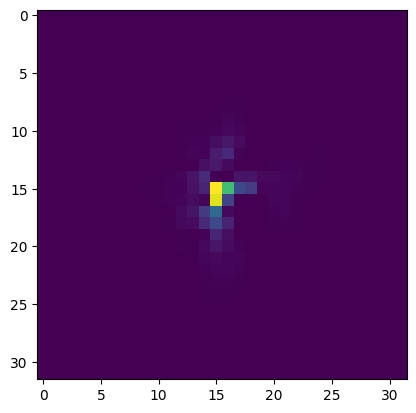

In [136]:
plt.imshow(H_components[0])


# AMI

In [26]:
def compute_AMI(partition_1,partition_2):
    """Computes AMI of two partitions.

    Parameters:
        partition_1 (np.array): Encoding for partition 1.
        partition_2 (np.array): Encoding for partition 2.

    Returns:
        AMI (float): AMI of the two partitions.
    """
    # check if partitions are defined on the same underlying space
    assert len(partition_1) == len(partition_2), "Partition arrays must have same length"

    # get number of points
    N = len(partition_1)

    # get communities as sets from partition 1
    communities_1 = []
    for index in np.unique(partition_1):
        community = set(np.where(partition_1==index)[0])
        communities_1.append(community)

    # get communities as sets from partition 2
    communities_2 = []
    for index in np.unique(partition_2):
        community = set(np.where(partition_2==index)[0])
        communities_2.append(community)

    # compute number of communities
    n1 = len(communities_1)
    n2 = len(communities_2)

    # compute probabilities for the two partitions
    p1 = np.asarray([len(community) for community in communities_1]) / N        # <-- SOLUTION
    p2 = np.asarray([len(community) for community in communities_2]) / N        # <-- SOLUTION

    # compute joint probabilities
    n12 = np.zeros((n1,n2))
    for i in range(n1):
        for j in range(n2):
            n12[i,j] = len(communities_1[i].intersection(communities_2[j]))   # <-- SOLUTION

    # compute entropy
    H1 = - np.sum(p1 * np.log(p1)) 
    H2 = - np.sum(p2 * np.log(p2))

    # compute mutual information
    MI = 0
    for i in range(n1):
        for j in range(n2):
            if p12[i,j] > 0:
                MI += p12[i,j] * np.log(p12[i,j]/(p1[i]*p2[j])) 

    # compute EMI
    for i in range(n1):
        for j in range(n2):
            for 

    # compute NVI
    NVI = (E1 + E2 - 2 * MI) / (E1 + E2 - MI)   # <-- SOLUTION

    return NVI

# GMM

In [3]:
import copy

class GMModel:
    """Struct to define Gaussian Mixture Model.
        Attributes:
            X (np.ndarray): the samples array, shape (N, p).
            k (int): number of mixture components, i.e. number of clusters.
            weights (np.ndarray): mixture weights.
            mu (np.ndarray): mixture component means for each cluster.
            sigma (np.ndarray): mixture component covariance matrix for each cluster
    """

    def __init__(self, X, k):
        """Initialises parameters through random split of the data"""

        self.k = k

        # initial weights given to each cluster are stored in pi or P(Ci=j)
        self.pi = np.full(shape=self.k, fill_value=1/self.k)

        # initial weights given to each data point wrt to each cluster or P(Xi|Ci=j)
        self.weights = np.full(shape=X.shape, fill_value=1/self.k)

        n, m = X.shape
        # dataset is divided randomly into k parts of unequal sizes
        random_row = np.random.randint(low=0, high=n, size=self.k)

        # initial value of mean of k Gaussians
        self.mu = [ X[row_index,:] for row_index in random_row ]

        # initial value of covariance matrix of k Gaussians
        self.sigma = [np.cov(X.T) for _ in range(self.k) ]

    def copy(self):
        """Return an isolated copy."""
        return copy.deepcopy(self)

In [13]:
## EDIT THIS FUNCTION
def cluster_probabilities(gmm, X):
    """
    Predicts probability of each data point with respect to each cluster

    Args:
        gmm (GMModel): the GMM model.
        X (np.ndarray): the samples array, shape: (N, p).

    Returns:
        (np.ndarray): weights of each data point w.r.t each cluster, shape (N, k)
    """

    # n has the number of rows while p has the number of columns of dataset X
    n, p = X.shape
    # Creates a n*k matrix denoting likelihood belonging to each cluster
    likelihood = np.zeros((n, gmm.k))
    for i in range(gmm.k):
        # likelihood of data belonging to i-th cluster
        distribution = scipy.stats.multivariate_normal(mean=gmm.mu[i],
                                           cov=gmm.sigma[i])
        likelihood[:,i] = distribution.pdf(X)

    numerator = likelihood * gmm.pi # <-- SOLUTION
    denominator = numerator.sum(axis=1, keepdims=True) # <-- SOLUTION
    weights = numerator / denominator
    return weights

In [14]:
## EDIT THIS FUNCTION
def predict(gmm, X):
    """Performs hard clustering."""
    weights = cluster_probabilities(gmm,X)
    return np.argmax(weights, axis=1) # <-- SOLUTION

In [37]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def gmm_plot(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = predict(gmm, X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=10, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights.max()
    for pos, covar, w in zip(gmm.mu, gmm.sigma, gmm.pi):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    return ax

In [38]:
## EDIT THIS FUNCTION
def gmm_fit_step(gmm, X):
    """
    Performs an EM step by updating all parameters.

    Args:
        gmm (GMModel): the current GMM model.
        X (np.ndarray): the samples array, shape: (N, p).

    Returns:
        gmm (GMModle): an updated GMM model after applying the E-M steps.
    """
    gmm = gmm.copy()

    # E-Step: update weights and pi holding mu and sigma constant
    weights = cluster_probabilities(gmm, X) # <-- SOLUTION
    gmm.pi = weights.mean(axis=0) # <-- SOLUTION

    # M-Step: update mu and sigma holding pi and weights constant
    for i in range(gmm.k):
        weight = weights[:, [i]]
        total_weight = weight.sum()

        gmm.mu[i] = (X * weight).sum(axis=0) / total_weight # <-- SOLUTION
        gmm.sigma[i] = np.cov((X-gmm.mu[i]).T,
                              aweights=(weight/total_weight).flatten(),
                              bias=True) # <-- SOLUTION (check np.cov documentation for weighted computation)

    return gmm

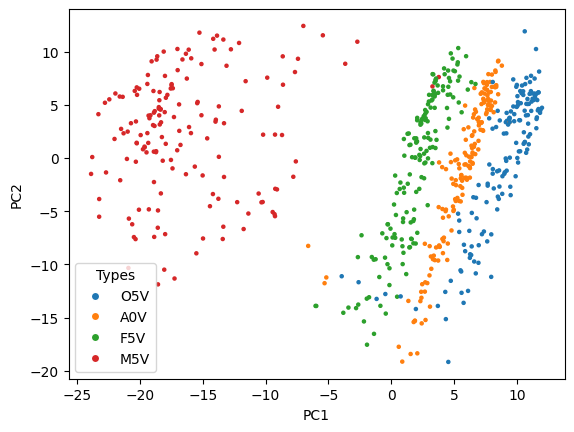

In [39]:
plt.scatter(X2_pca[:, 0], X2_pca[:, 1], c=color_type, s=5)

# create legend for node types
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Types')

plt.xlabel('PC1')
plt.ylabel('PC2');

C:\Users\phily\AppData\Local\Temp\ipykernel_7100\3669392977.py:19: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


<AxesSubplot: >

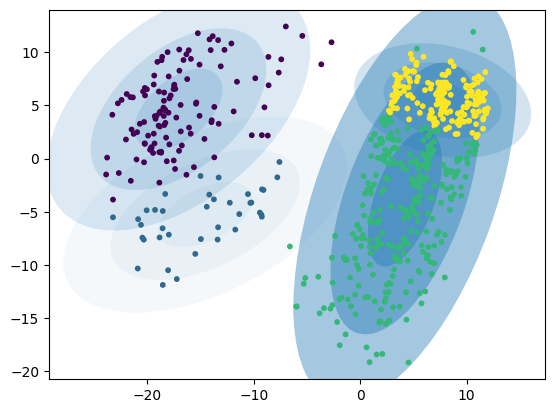

In [57]:
gmm = GMModel(X2_pca[:, :2], 4)

for _ in range(100):
    gmm = gmm_fit_step(gmm, X2_pca[:, :2])
gmm_plot(gmm, X2_pca[:, :2])

# Hierarchical Clustering

In [58]:
# EDIT THIS FUNCTION
def compute_within_distance(centroids, X, labels):
    """
    Compute the within-cluster distance.

    Args:
        centroids (np.ndarray): the centroids array, with shape (k, p).
        X (np.ndarray): the samples array, with shape (N, p).
        labels (np.ndarray): the cluster index of each sample, with shape (N,).

    Retruns:
        (float): the within-cluster distance.
    """
    within_distance = 0.0
    k, p = centroids.shape

    for l in range(len(centroids)):
        centroid = centroids[l]
        # Applying aggregate computations on `NaN` values
        # can propagate the `NaN` to the results.
        # In this case we skip the `NaN` centroid,
        # which is effectively of an empty cluster.
        if np.isnan(centroid).any():
            continue

        # Select samples belonging to label=l.
        X_cluster = X[labels == l]

        # EDIT THE NEXT LINES
        # You need to add the `X_cluster` contribution to `within_distance`

        # 1. Compute the cluster contribution.
        cluster_se = (X_cluster - centroid)**2 # <-- SOLUTION
        assert cluster_se.shape == (len(X_cluster), p) # <-- SOLUTION
        # 2. Accumulate
        within_distance += np.sum(cluster_se) # <-- SOLUTION

    return within_distance


In [59]:
# EDIT THIS FUNCTION
def compute_centroids(k, X, labels):
    """
    Compute the centroids of the clustered points X.

    Args:
        k (int): total number of clusters.
        X (np.ndarray): data points, with shape (N, p)
        labels (np.ndarray): cluster assignments for each sample in X, with shape (N,).

    Returns:
        (np.ndarray): the centroids of the k clusters, with shape (k, p).
    """
    N, p = X.shape

    centroids = np.zeros((k, p))

    # EDIT THE NEXT LINES
    for label in range(k):
        cluster_X_l = X[labels == label] # <-- SOLUTION
        centroids[label] = cluster_X_l.mean(axis=0) # <-- SOLUTION

    return centroids


In [60]:
# EDIT THIS FUNCTION
def kmeans_assignments(centroids, X):
    """
    Assign every example to the index of the closest centroid.

    Args:
        centroids (np.ndarray): The centroids of the k clusters, shape: (k, p).
        X (np.ndarray): The samples array, shape (N, p).

    Returns:
        (np.ndarray): an assignment matrix to k clusters, by their indices.
    """
    k, p = centroids.shape
    N, _ = X.shape

    # Compute distances between data points and centroids. Assumed shape: (k, N).
    distances = np.vstack([np.linalg.norm(X - c, axis=1) for c in centroids]) # <-- SOLUTION
    # Note: If any centroid has NaN, the NaN value will propagate into the
    # distance corresponding row, we need to skip that row next when we search
    # for the closest centroid.

    assert distances.shape == (k, N), f"Unexpected shape {distances.shape} != {(k, N)}"
    # Assignments are computed by finding the centroid with the minimum distance
    # for each sample. The np.nanargmin returns the index of the minimum values
    # in `distances` scanning the rows (axis=0) for each column,
    # while skipping any nan value found.
    return np.nanargmin(distances, axis=0)



In [61]:
# EDIT THIS FUNCTION
def kmeans_clustering(X, k,
                      max_iters=1000,
                      epsilon=0.0,
                      callback=None):
    """
    Apply k-means clustering algorithm on the samples in `X` to generate
    k clusters.

    Notes:
      The main steps followed here are described previously:
        1. randomly assignments of the points to $k$-clusters.
        2. compute the centroid of each of the $k$- clusters.
        3. reassign each point to the closest centroid.
        4. repeat steps (2) and (3) until:
            - assignments/labels do not change, or
            - the within-distance $W(C)$ converges with `epsilon` tolerence.
            - or the number of iterations exceeds `max_iters`.


    Args:
        X (np.ndarray): The samples array, shape: (N, p).
        k (int): The number of clusters.
        max_iters (int): Maximum number of iterations.
        epsilon (float): The minimum change in the within-distance to continue.
        callback (Callable): a function to be called on the assignments,
            the centroids, and within-distance after each iteration, default is None.

    Returns:
        Tuple[np.ndarray, np.ndarray]: the assignments array to k clusters with
            shape (N,) and the centroids array
    """
    # Step 1: randomly initialise the cluster assignments.
    labels = np.random.choice(k, size=len(X), replace=True) # <-- SOLUTION

    within_distance = np.inf

    for _ in range(max_iters):
        # Step 2: compute the centroids
        centroids = compute_centroids(k, X, labels) # <-- SOLUTION

        if callback:
            callback(labels, centroids)

        # Step 3: reassignments.
        new_labels = kmeans_assignments(centroids, X) # <-- SOLUTION

        _within_distance = compute_within_distance(centroids, X, labels)

        # Step 4: repeat (2) and (3) until a termination condition.
        if all(labels == new_labels) or abs(_within_distance - within_distance) < epsilon: # <-- SOLUTION
            break

        labels = new_labels
        within_distance = _within_distance


    return labels, centroids, within_distance


In [ ]:
## EDIT THIS FUNCTION
def hierarchical_clustering(points, distances, linkage):
    """
    The agglomerative hierarchical clustering algorithm start with every point as a single
    cluster and each iteration merges two clusters into one. We may wish to store all the
    intermediate clustering results with respect to the number of clusters left.

    Args:
     points: A numpy array of points having the shape (N, D),
          where N is the number of points and D is the number of features.
     distances: A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
     linkage: A linkage function from the above to call to compute the linkage values between two clusters.

    Returns:
     (np.ndarray):  A numpy array of shape (N, N) of which each row stores the clustering assignment at each level.
     The first row, i.e. a[0, :], represents the highest level of clustering where all columns have the same index value.
     The second row, i.e. a[1, :], represents all the points assigned into two cluster indices.
     The last row, i.e. a[N - 1, :], represents the points assigned into N - 1 cluster indices.
    """
    N, D = points.shape
    assignments = np.zeros((N, N))

    # Begin with every point in its own cluster
    current_assignment = np.zeros(N)   # <-- SOLUTION

    # The id to be assigned for the next merged cluster
    next_cluster_id = 1

    # Begin from level (N - 1) to level 1
    for level in tqdm(range(N)):

        cluster_ids = np.unique(current_assignment)

        min_d = np.inf

        # Initialize the cluster ids to be merged in this iteration.
        cluster_a, cluster_b = (-1, -1)

        # Now find the two clusters that have the minimum distance in between.
        for i in range(cluster_ids.size):   # <-- SOLUTION
            
            for j in range(i + 1, cluster_ids.size):    # <-- SOLUTION
                cluster_i = cluster_ids[i]  # <-- SOLUTION
                cluster_j = cluster_ids[j]  # <-- SOLUTION
                d = linkage(distances, current_assignment, cluster_i, cluster_j)    # <-- SOLUTION
                if d < min_d:   # <-- SOLUTION
                    min_d = d   # <-- SOLUTION
                    cluster_a, cluster_b = (cluster_i, cluster_j)   # <-- SOLUTION


        # Merge the two clusters
        current_assignment[(current_assignment == cluster_a) | (current_assignment == cluster_b)] = next_cluster_id # <-- SOLUTION

        next_cluster_id += 1
        # Store the current cluster assignment into the assignments array.
        assignments[level, :] = current_assignment

    return assignments